<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/SVMmodel_trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-processingg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ADS2002-Project-CatheterPlacement

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1sDmXQTrvwQhCF8mWDh9phnwM9axaYjjb/ADS2002-Project-CatheterPlacement


In [38]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [39]:
train = pd.read_csv('Data/train.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [40]:
filenames = os.listdir("Data/train")
train_imgs = []
FileIDs = []
lst = []

desired_channels = 3

count = 0
for file in filenames:
    if count == 500:
        break

    # Making sure the images are the same pixel size
    img = Image.open(f"Data/train/{file}")
    img = img.resize((224, 224))
    img = np.array(img)

    # Ensure that the image has 3 channels (RGB)
    if img.shape[-1] != 3:
        img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

    # Flatten the image and add it to the list
    img = img.reshape(-1)
    train_imgs.append(img)

    # Save filename for later
    FileIDs.append(file)

    count += 1

In [28]:
# Convert the list of flattened images to a numpy array
train_imgs = np.array(train_imgs)

In [29]:
#extracting just the CVC labels
train_data = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train.csv")
CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
CVC_train.set_index('StudyInstanceUID', inplace=True)
CVC_train.head()

,CVC - Abnormal,CVC - Borderline,CVC - Normal
StudyInstanceUID,,,
1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561,0,0,0
1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729,0,0,1
1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,1,0
1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744,1,0,0
1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175,0,0,1


In [30]:
CVC_train['CVC - Present'] = np.where((CVC_train['CVC - Abnormal'] == 0) & (CVC_train['CVC - Normal'] == 0) & (CVC_train['CVC - Borderline'] == 0), 0, 1)

<ipython-input-30-8abb49231a47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CVC_train['CVC - Present'] = np.where((CVC_train['CVC - Abnormal'] == 0) & (CVC_train['CVC - Normal'] == 0) & (CVC_train['CVC - Borderline'] == 0), 0, 1)


In [31]:
CVC_train['CVC - Present'].value_counts()

1    29333
0      750
Name: CVC - Present, dtype: int64

In [33]:
# #cleaning up the labels
# UID = []
# for i in range(len(FileIDs)):
#   UID.append(FileIDs[i].replace(".jpg",""))

# UID[0:10]

In [34]:
# Cleaning up the labels
UID = []
for i in range(len(FileIDs)):
    UID.append(FileIDs[i].replace(".jpg", ""))

UID[0:10]

train_labels = []

for ID in UID:
    train_labels.append(CVC_train.loc[ID]['CVC - Present'])

In [35]:
# Convert the list of labels to a numpy array
train_labels = np.array(train_labels)


In [36]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)


In [37]:
# Initialize the SVM model
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1)  # You can experiment with different kernels and hyperparameters

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      0.99        99

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM model

Linear model:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)


In [23]:
# Flatten the images in X_train and X_test
num_train_samples, height, width, channels = X_train.shape
X_train_flattened = X_train.reshape(num_train_samples, -1)

RBF kernel:

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the SVM model with RBF kernel
svm_model_rbf = SVC(kernel='rbf', C=1)  # You can experiment with different values of C

# Train the SVM model
svm_model_rbf.fit(X_train_flattened, y_train)

# Predict on the testing set
y_pred_rbf = svm_model_rbf.predict(X_test_flattened)

# Evaluate the model
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
classification_rep_rbf = classification_report(y_test, y_pred_rbf)

print("RBF Kernel SVM Results:")
print(f"Accuracy: {accuracy_rbf}")
print("Classification Report:")
print(classification_rep_rbf)


RBF Kernel SVM Results:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      0.99        99

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[ 0  1]
 [ 0 99]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      1.00      0.99        99

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


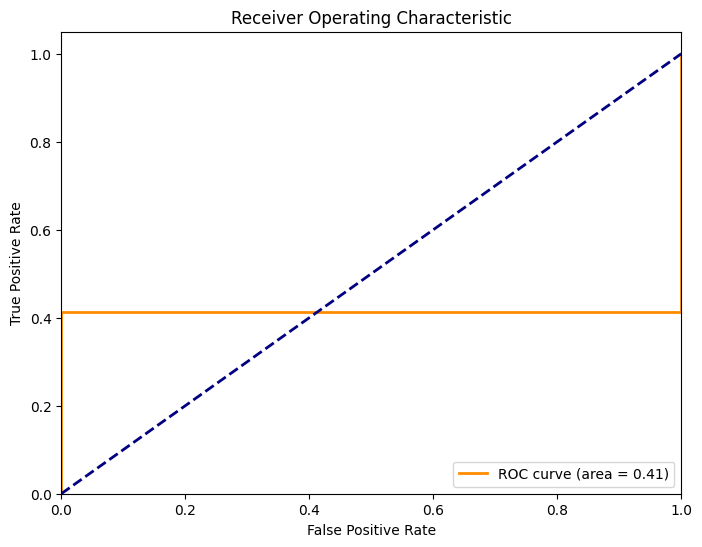

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate ROC curve and AUC (Area Under the Curve)
y_pred_prob = svm_model.decision_function(X_test_flattened)  # Get decision scores
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [42]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load your preprocessed data and labels
# Replace X_train and y_train with your actual data and labels
# Ensure X_train is a 2D array, e.g., (num_samples, num_features)
# Ensure y_train is a 1D array or list of labels, e.g., (num_samples,)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the SVM model with class weights
svm_model = SVC(kernel='linear', class_weight='balanced', C=1.0)  # You can experiment with different kernels and hyperparameters

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.8875
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      0.91      0.94        78

    accuracy                           0.89        80
   macro avg       0.49      0.46      0.47        80
weighted avg       0.95      0.89      0.92        80

